# N3Pseq pA length estimation
## cdna_std
DNA Standards sequenced with R10 chemistry (Check out [this presentation](https://docs.google.com/presentation/d/1_Qo0ykExvrT1ctika1JHmOElLGYM3c0ko53zu4NtXYA/edit#slide=id.p) for the information about them)
Here is the location to the following files:
- /no_backup/enovoa/users/boguzhan/FINAL_Nano3Pseq_R10/Datasets_for_Leszek


In here you will find :
- R9_Yeast_Sequin  (R9 runs of TGIRT and Induro)
- R10  (R10 runs of Induro 2 reps and DNA standards)
- references (references used for yeast+sequin and DNA standards)

cDNA standards will be important to know two things:
- Length estimation accuracy : we have standards with polyA tail length between 0-120 nt. These can be used to finetune the tail length estimation.
- Tail content: 1U,3U,5U,5G, 5C , IntG are the non-A base  addition to a 30 nt polyA tail. In the presentation, I show some IGV snapshots of these DNAs, You will see that content can easily be seen on IGV. I think these standards could be used to add tail content estimation to the pipeline and perhaps we could already get the counts of non-A bases on the tail.

In [1]:
import mappy
import numpy as np
import pysam
import re

# barcode end (CAGCACCT) + primer ACTTGCCTGTCGCTCTATCTGCAGAGCAGAG
primer = "CAGCACCTACTTGCCTGTCGCTCTATCTGCAGAGCAGAG" + "TTT"
fasta = "primer.fa"
with open(fasta, "wt") as out:
    out.write(f">primer\n{primer}\n")

kwargs = {"k": 6, "w": 3, "scoring": [2, 3, 3, 2, 7, 1, 0], "min_cnt": 1, "min_chain_score": 13, "min_dp_score": 20, "best_n": 3}
aligner = mappy.Aligner(fasta, **kwargs)

seq = 'ATGTTTATGTTGACGCCTTTCGTTCAGTTACGTATTGCTAAGGTTAAGCATAGTTCTGCATGATGGGTTAGCAGCACCTACTTGCCTGTCGCTCTATCTGCAGAGCAGGTGCTTCCCTGTCGCTCTATCTGCAGAGCAGAGTTTTTTTTTTTTTTTTTTTTGTAAAGAAACTGTACGCTTGTCGCAGATGATGTCATACGTATTTTATTTACAGGTGTCATTAATATATATATATATATATACGTATACG'
for h in aligner.map(seq): print(h.q_st, h.q_en, h.strand, h.r_st, h.r_en, h.cigar, h.mapq)

71 108 1 0 37 [[37, 0]] 33


In [2]:
import os, sys
import numpy as np
import parasail
import pysam
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def correct_alg(cigar, ts, qs, w=6, k=3, pat=re.compile(r'\d+')):
    """Correct alignment skipping initial deletion
    
    Return corrected: 
    - cigar 
    - target start
    - query start
    - number of anchors
    - edit distance (NM)
    - aligned query bases
    """
    idx = n_anchors = nm = qalg = talg = 0
    pe = 0
    diff = w-k
    for i, m in enumerate(pat.finditer(cigar)):
        e = m.end()
        l = int(cigar[pe:e])
        op = cigar[e:e+1]
        pe = e+1
        # skip initial deletion
        if i==0 and op in "ID":
            idx = pe
            if op == "D": ts += l
            elif op == "I": qs += l
        # update number of anchors
        elif op=="=":
            n = (l-diff) // k
            if n>0:
                n_anchors += n
            qalg += l
            talg += l
        # count mismatches
        elif op!="S":
            nm += l
            if op!="D": qalg += l
            if op!="I": talg += l
    return cigar[idx:], ts, qs, n_anchors, nm, qalg, talg

def get_pt_boundaries(seq, pt_start, pat=re.compile(r'((\w?T{2,}\w?)+)', re.IGNORECASE), before=10, after=50):
    start = end = 0
    for m in pat.finditer(seq[pt_start-before:pt_start+after]):
        s, e = m.span()
        if s>2*before: continue
        s = pt_start + s - before + 1 # we include nonT start/end
        e = pt_start + e - before - 1 # we include nonT start/end
        if e-s > end - start:
            start, end = s, e
    return start, end

def alg2pt(a, primer, profile, open_penalty, extend_penalty, extension=5, analyse_first=250):
    """Return sequence flanking pt, pt start, pt end, pt length, pt sequence, alignment score, identity and cigar"""
    seq = a.get_forward_sequence()
    r = parasail.sw_trace_striped_profile_16(profile, seq[:analyse_first], open_penalty, extend_penalty) # 41.6 µs vs 13.4 µs :200
    # filter TODO: scoring
    #if r.score<50: continue
    cigar = r.cigar.decode.decode() # 2.62 µs
    score, ts, te, qs, qe = r.score, r.cigar.beg_ref, r.end_ref, r.cigar.beg_query, r.end_query
    cigar, ts, qs, m, nm, qalg, talg = correct_alg(cigar, ts, qs) # 2.6 µs
    # get polyT length in bases
    end_skip = len(primer)-qe-1
    if qs: cigar = f"{qs}S" + cigar
    if end_skip: cigar += f"{end_skip}S"
    pt_start = te + end_skip - 2
    # get pt boundaries
    s, e = get_pt_boundaries(seq, pt_start)
    # unload tags
    tags = {k: v for k, v in a.tags}
    identity = round(1-nm/qalg, 3)
    mv = np.array(tags['mv'])
    stride, move = mv[0], mv[1:]
    move_pos = np.argwhere(move==1).flatten()
    steps = move_pos[1:]-move_pos[:-1]; steps
    pt_len = round(steps[s-extension:e+extension+1].sum()/steps[e+extension+1:].mean() - 2*extension, 1); pt_len
    return seq[pt_start-10:pt_start+50], s, e, pt_len, seq[s:e], r.score, identity, cigar

### polyA length

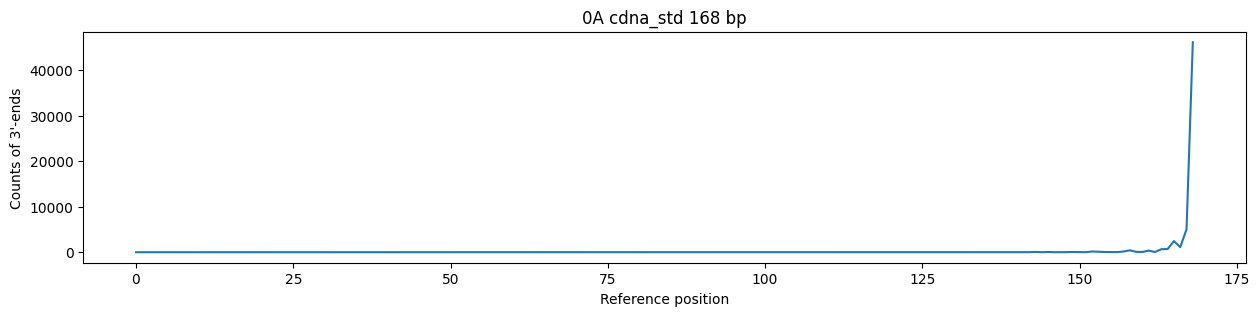

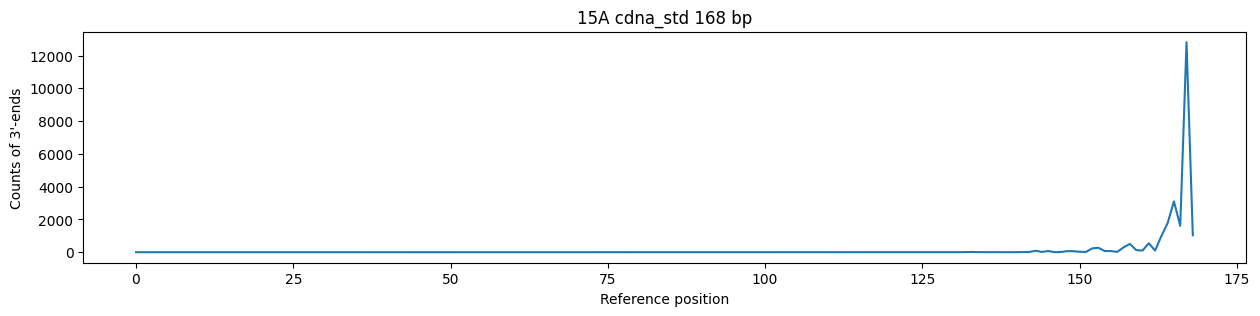

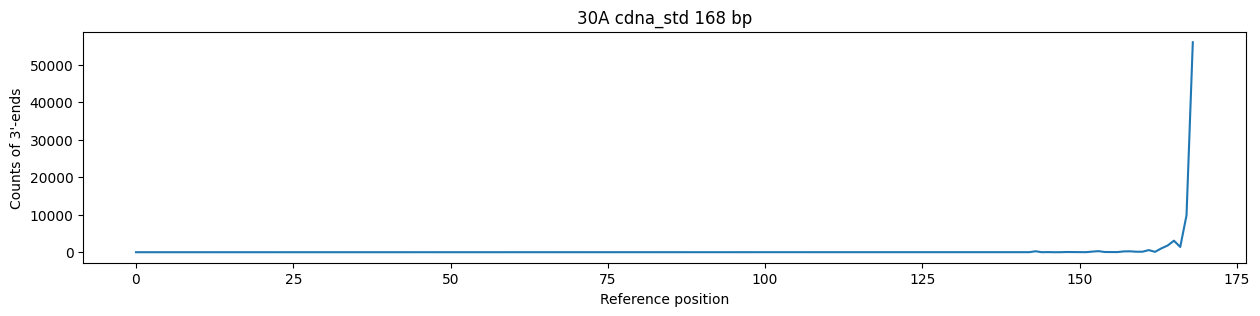

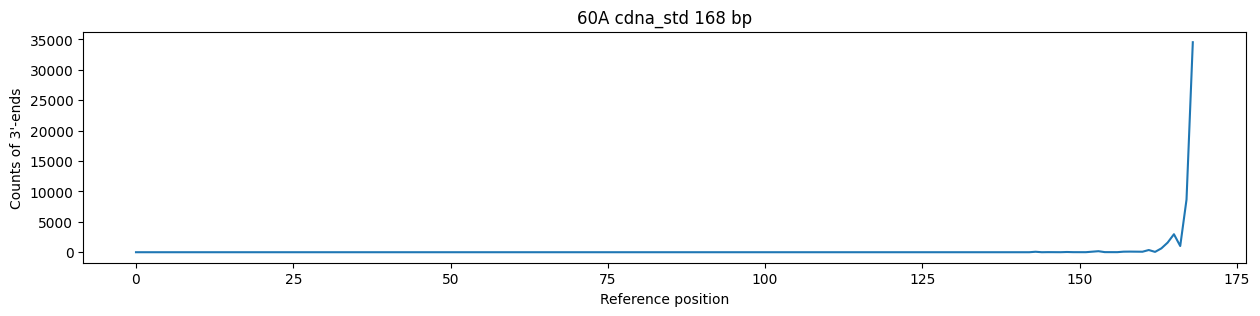

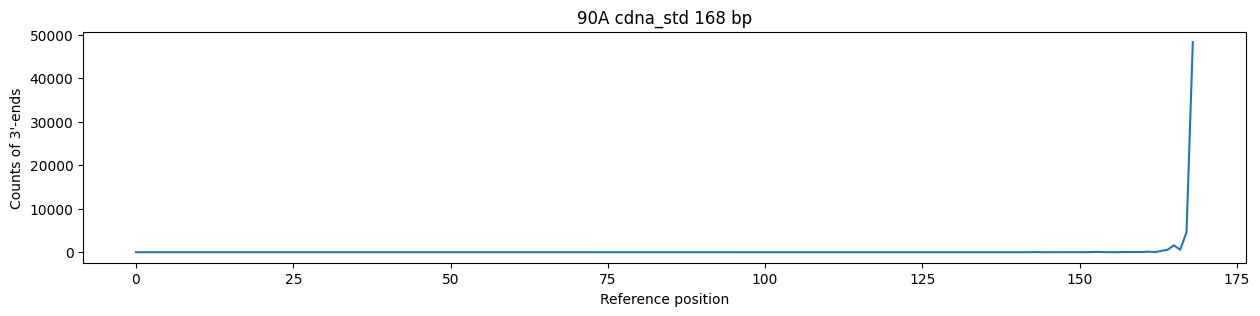

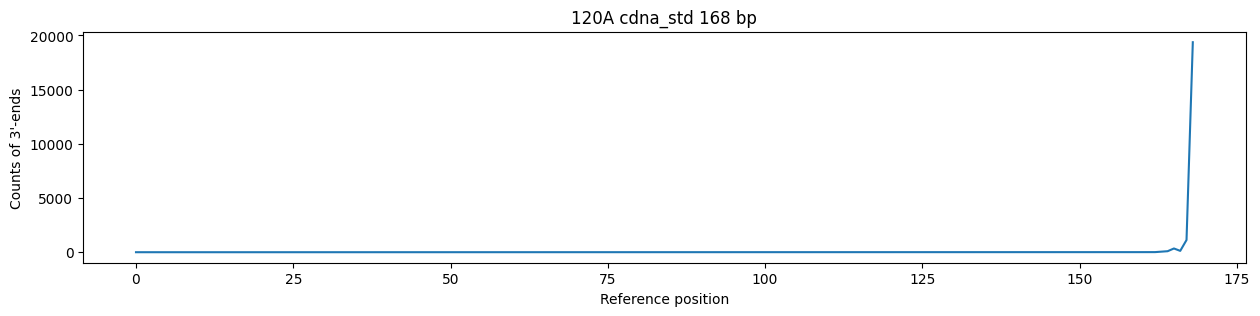

In [3]:
mapq = 10
bampat = "/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2.R10_cdna_std/N3PS_R10_DNAStd_DoradoSUP_%sA.bam"
pa_lengths = (0, 15, 30, 60, 90, 120)
dframes = []
for pa_len in pa_lengths:
    bam = bampat%pa_len
    if not os.path.isfile(bam): continue
    sam = pysam.AlignmentFile(bam)
    ref2len = {r: l for r, l in zip(sam.references, sam.lengths)}#; ref2len
    refs = list(ref2len.keys()); refs    
    for ref in refs:
        counts = np.zeros(ref2len[ref]+1, dtype="uint16")
        for a in sam.fetch(ref):
            if a.is_secondary or a.is_supplementary or a.mapq<mapq: continue
            e = a.aend if a.is_reverse else a.pos
            counts[e] += 1
        if sum(counts)<10: continue
        fig, ax = plt.subplots(figsize=(15, 3))
        ax.plot(np.arange(len(counts)), counts)
        ax.set_title(f"{pa_len}A {ref} {ref2len[ref]} bp")
        ax.set_xlabel("Reference position")
        ax.set_ylabel("Counts of 3'-ends")

### estimate pT length

In [23]:
print(primer)

CAGCACCTCTTCCGATCACTTGCCTGTCGCTCTATCTTTT


In [18]:
%%time
#primer = "CAGCACCT" + "ACTTGCCTGTCGCTCTATCTGCAGAGCAGAG" + "TTT"
primer = "CAGCACCT" + "CTTCCGATCACTTGCCTGTCGCTCTATCT" + "TTT" # for some reason here the primer is different?!
minscore=20; scoring=(2, 3, 3, 2)
match_score, mismatch_penalty, open_penalty, extend_penalty = scoring
matrix = parasail.matrix_create("ACGT", match_score, -mismatch_penalty)
profile = parasail.profile_create_16(primer, matrix)

mapq = 10
bampat = "/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2.R10_cdna_std/N3PS_R10_DNAStd_DoradoSUP_%sA.bam"
bamfltpat = "/no_backup/enovoa/users/boguzhan/FINAL_Nano3Pseq_R10/Datasets_for_Leszek/R10/DNA_Standards/bam_complete/N3PS_R10_DNAStd_DoradoSUP_%sA.filteredbyreadstart.bam"
pa_lengths = (0, 15, 30, 60, 90, 120)
dframes = []
for pa_len in pa_lengths:
    data = []
    sam = pysam.AlignmentFile(bampat%pa_len)
    # filter by read id
    #'''
    readids = set()
    '''
    sam2 = pysam.AlignmentFile(bamfltpat%pa_len)
    readids = set([a.qname for a in sam2])
    #'''
    for ref in refs:
        i = 0
        for a in sam.fetch(ref):
            if readids and a.qname not in readids: continue
            e = a.aend if a.is_reverse else a.pos
            if a.is_secondary or a.is_supplementary or a.mapq<mapq: continue
            i += 1
            read_id = a.qname
            seq, pt_s, pt_e, pt_len, pt_seq, alg_score, alg_identity, cigar = alg2pt(a, primer, profile, open_penalty, extend_penalty)
            #data.append((ref, read_id, pt_len, alg_score, alg_identity, cigar, ref2len[ref]-e))
            data.append((pt_len, alg_score, alg_identity, ref2len[ref]-e))
    print(pa_len, i)
    df = pd.DataFrame(data, columns=("pt", "score", "identity", "dist")); df.head()
    df["sample"] = pa_len
    dframes.append(df)
    
df = pd.concat(dframes).reset_index(); df.head()

0 41339
15 95204
30 14016
60 19783
90 11150
120 2457
CPU times: user 24.1 s, sys: 168 ms, total: 24.3 s
Wall time: 24.9 s


/tmp/ipykernel_1535596/3415037345.py:82: RuntimeWarning: Mean of empty slice.
  pt_len = round(steps[s-extension:e+extension+1].sum()/steps[e+extension+1:].mean() - 2*extension, 1); pt_len
/home/lpryszcz/src/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,index,pt,score,identity,dist,sample
0,0,5.6,76,1.000,0,0
1,1,-1.9,76,1.000,0,0
2,2,3.8,50,0.842,0,0
3,3,3.5,47,0.842,0,0
4,4,5.6,76,1.000,0,0


In [19]:
df.groupby("sample").count().sum(axis=1)//5

sample
0      41339
15     95204
30     14016
60     19783
90     11150
120     2456
dtype: int64

In [20]:
df[df.dist<10].groupby("sample").count().sum(axis=1)//5

sample
0      41339
15     95204
30     14016
60     19783
90     11150
120     2456
dtype: int64

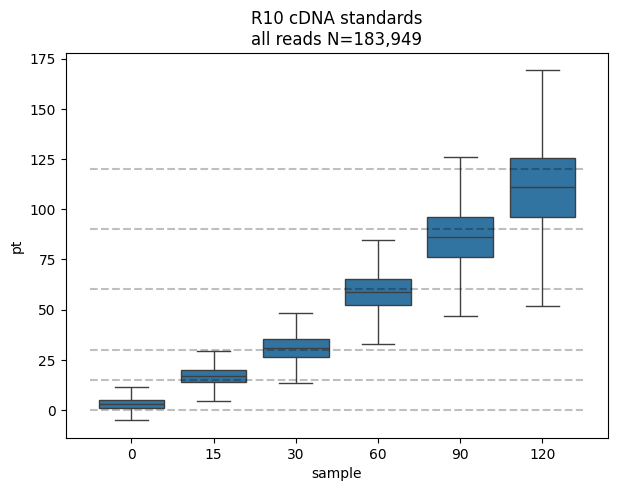

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, x="sample", y="pt", ax=ax, showfliers=False)
ax.set_title(f"R10 cDNA standards\nall reads N={df.shape[0]:,}") #f"{os.path.basename(bam)} N={len(df[df.dist<10])}"
#ax.set_ylim(-20,120)
ax.hlines(pa_lengths, *ax.get_xlim(), ls='--', color="black", alpha=0.25)
_ = plt.xticks() #rotation=90)

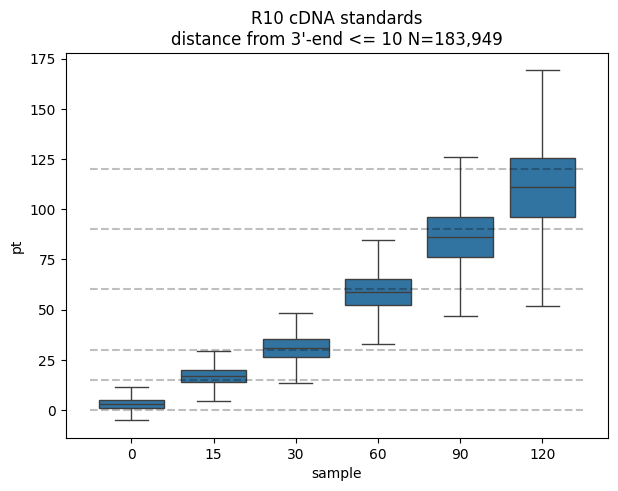

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df[df.dist<10], x="sample", y="pt", ax=ax, showfliers=False)
ax.set_title(f"R10 cDNA standards\ndistance from 3'-end <= 10 N={df[df.dist<10].shape[0]:,}")
#ax.set_ylim(-20,120)
ax.hlines(pa_lengths, *ax.get_xlim(), ls='--', color="black", alpha=0.25)
_ = plt.xticks() #rotation=90)

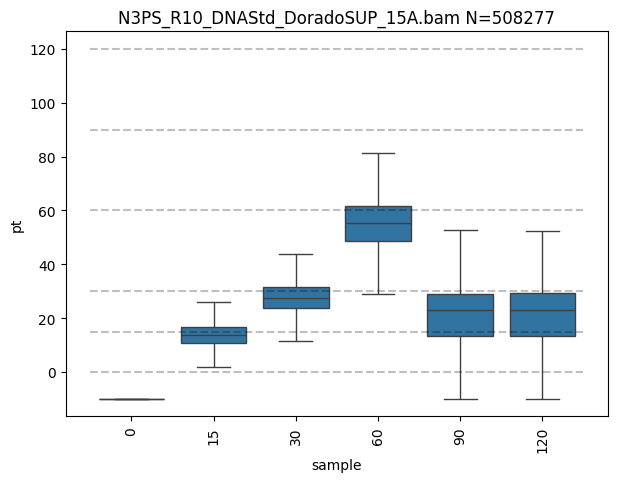

In [26]:
# this is with wrong primer sequence!
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df[df.dist<10], x="sample", y="pt", ax=ax, showfliers=False)
ax.set_title("R10 cDNA standards\ndistance from 3'-end <= 10") #f"{os.path.basename(bam)} N={len(df[df.dist<10])}"
#ax.set_ylim(-20,120)
ax.hlines(pa_lengths, *ax.get_xlim(), ls='--', color="black", alpha=0.25)
_ = plt.xticks(rotation=90)

In [35]:
bam

'/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2.R10_cdna_std/N3PS_R10_DNAStd_DoradoSUP_15A.bam'

In [17]:
def estimate_pA(bam, ref, mapq=10, max_dist=10, maxi=100):
    sam = pysam.AlignmentFile(bam)
    ref2len = {r: l for r, l in zip(sam.references, sam.lengths)}#; ref2len
    
    #primer = "CAGCACCT" + "ACTTGCCTGTCGCTCTATCTGCAGAGCAGAG" + "TTT"
    primer = "CAGCACCT" + "CTTCCGATCACTTGCCTGTCGCTCTATCT" + "TTT"
    minscore=20; scoring=(2, 3, 3, 2)
    match_score, mismatch_penalty, open_penalty, extend_penalty = scoring
    matrix = parasail.matrix_create("ACGT", match_score, -mismatch_penalty)
    profile = parasail.profile_create_16(primer, matrix)
    
    counts = np.zeros(ref2len[ref]+1, dtype="uint16")
    print("End.......PolyT...Read pt_start pt_end pT_length pT_seq score identity cigar")
    i = 0
    for a in sam.fetch(ref):
        e = a.aend if a.is_reverse else a.pos
        if a.is_secondary or a.is_supplementary or a.mapq<mapq or abs(e-ref2len[ref])>max_dist: continue
        i += 1
        seq, pt_s, pt_e, pt_len, pt_seq, alg_score, alg_identity, cigar = alg2pt(a, primer, profile, open_penalty, extend_penalty, analyse_first=150)
        print(seq, pt_s, pt_e, pt_len, pt_seq, alg_score, alg_identity, cigar, e-ref2len[ref])
        if i==maxi: break
        
#estimate_pA("R10_Dorado_supv5_YeastmRNA.bam", "R2_117_1")
estimate_pA("/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2.R10_cdna_std/N3PS_R10_DNAStd_DoradoSUP_60A.bam", 'cdna_std', maxi=10)

End.......PolyT...Read pt_start pt_end pT_length pT_seq score identity cigar
GCTCTCTTCTTTTTTTGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATCTTTATAGG 95 105 31.0 TTCTTTTTTT 64 0.9 22=1D3=1X7=1D1X6= 0
GGCTTCTGCTTTGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGTCATCAAGATGGA 102 139 66.3 TTTGTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT 37 0.744 7=2D1=1X2=2X3=1D11=1X2=1D3=1I1X4=1S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 108 110 1.2 TT 61 0.895 4=1X4=2D3=1X25=2S 0
GCTCTATCTTCTTTTTTTGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTAT 111 121 17.2 TTCTTTTTTT 72 0.925 25=2D13=1D2= 0
GCTCTATCTTCTTTTTGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGC 102 110 59.9 TTCTTTTT 77 0.975 38=1D2= 0
GCTCTATCTTCTTTTTTTTTTGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATT 101 114 49.9 TTCTTTTTTTTTT 77 0.975 38=1D2= 0
GACTAGCTCCACTTTTAAGAATTATTTATGCAATTAAATACATGGGTGACCAAAAGAGCG 105 111 4.4 TTATTT 17 0.909 8=1I2=29S 0
TCGCTCTGCTTTACTGAATAGAAACAAGCTAGCTCCACTTTTAAGAATTATTTATGCAAT 93 96 61.6 TTT 63 0.923 9=1I23=1I1X4=1S -1
GCTCTCTTCTTTTTTTGTAAATAGA

In [55]:
estimate_pA("/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2.R10_cdna_std/N3PS_R10_DNAStd_DoradoSUP_30A.bam", 'cdna_std', maxi=10)

End.......PolyT...Read pt_start pt_end pT_length pT_seq score identity cigar
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 100 102 -2.8 TT 66 0.947 17=1I1X19=2S 0
CGCTCTATCTTCTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATTA 105 107 6.3 TT 76 1.0 38=2S -1
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCACTTTTAAGAATTATTTATGCAATTG 98 100 3.8 TT 59 0.895 19=1D2=1X2=2I12=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTAAGAATTATTTATGCAATTA 114 116 2.0 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTTCACTCCACTTTTAAGAATTATTTATGCAAT 101 103 4.1 TT 63 0.921 16=1X1=1D3=1X16=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 107 109 -0.3 TT 69 0.921 6=3D32=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 105 107 1.0 TT 70 0.947 11=1D3=1D24=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTGTGATAACT 99 101 2.1 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 94 96 1.6 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTA

In [56]:
estimate_pA("/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2.R10_cdna_std/N3PS_R10_DNAStd_DoradoSUP_0A.bam", 'cdna_std', maxi=10)

End.......PolyT...Read pt_start pt_end pT_length pT_seq score identity cigar
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTCGTTTATGCAATTAAATAC 100 102 4.1 TT 71 0.947 19=2D19=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 96 98 9.3 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 101 103 -0.8 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGGAAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAA 99 101 15.7 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATGAAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 105 107 5.9 TT 76 1.0 38=2S 0
ATCACTATCTTCGTAAATAGAAATAAGTTCCTCCACTTTTAAATTATTATCCCAATTTGA 111 113 -0.0 TT 54 0.868 22=1D3=1X1=2I1=1X7=2S 0
CGCTCTATCTTGGTATCTCAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATTA 96 98 -4.8 TT 76 1.0 38=2S -8
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCGGCTAGAATTATTTATTCAATTAAA 88 90 1.1 TT 68 0.947 16=1X1=1D20=2S 0
CGCTCTATCTTCGTAAATCGGAATGAATCTAGCTCCACTTTTAAGAATTATTTATGCAAT 103 105 16.4 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 98 100 1

In [58]:
estimate_pA("/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2.R10_cdna_std/N3PS_R10_DNAStd_DoradoSUP_90A.bam", 'cdna_std', maxi=100)

End.......PolyT...Read pt_start pt_end pT_length pT_seq score identity cigar
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 107 109 2.0 TT 66 0.947 16=1X2=1I18=2S 0
CGCTCTATCTTCGTAAATAAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAAT 97 99 4.5 TT 71 0.974 11=1I26=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 99 101 3.5 TT 67 0.947 11=2I25=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 94 96 0.8 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 102 104 1.5 TT 76 1.0 38=2S 0
CGCTCTATCTGCAGAAGCAAGTACTTGCTGTCGCTCTATCTCGTAAATAGAAATAGACTA 0 0 -10.0  40 1.0 17S20=3S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 102 104 2.1 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 101 103 5.0 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATGGGTTAACTCTTCCACTTTTAAGAATTATTTATGCA 103 105 3.7 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 99 101 2.2 TT 76 1.0 38=

In [60]:
estimate_pA("/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2.R10_cdna_std/N3PS_R10_DNAStd_DoradoSUP_120A.bam", 'cdna_std', maxi=1000)

End.......PolyT...Read pt_start pt_end pT_length pT_seq score identity cigar
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 104 106 3.4 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTTGGCTAGGATTACTTATGCAATTAAAT 107 109 1.0 TT 50 0.842 8=1D3=3X2=1D2=1I19=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 101 103 8.4 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 103 105 2.6 TT 76 1.0 38=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTAAGAATTATTTATGCAATTA 97 99 -2.0 TT 68 0.947 13=1D4=1X20=2S 0
TGTCCTGTCTTCATAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATTA 97 99 1.7 TT 48 0.816 4=1X4=2D19=3I2=1X4=2S -3
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTAAGAATTATTTATGCAATTA 100 102 -1.1 TT 71 0.974 9=1I28=2S 0
CGCTCTATCTTCGTAAATAGAAATAGACTGACTCCACTTTTAAGAATTATTTATGCAATT 99 101 4.0 TT 76 1.0 38=2S 0
GTCGCTCTCTTCGCAAATAGAAATAGACTAGCTCCACTTTTAAGAATTATTTATGCAATT 99 101 -4.4 TT 67 0.947 32=2I4=2S -2
CGCTCTATCTTCGTAAATAGAAATAGACTAGCTCCACTTTTAAGAA